In [396]:
#import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from matplotlib.colors import LinearSegmentedColormap

#suppress warnings thrown by the libraries imported
warnings.filterwarnings('ignore')

#for now we are converting every column to object type and we will be changing the columns as per requirement
#this is done because it causes issues in the analysis as a lot of irrelevant data is present.
loan = pd.read_csv('loan.csv', dtype=object)
#Print dataframe shape to get the idea of rows and columns
#Print the information of the loan dataframe
#Print the data types of the loan dataframe
print(loan.shape)
print(loan.info())
print(loan.dtypes)

#remove duplicates
loan = loan.drop_duplicates(keep='first', subset='id')

(39717, 111)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: object(111)
memory usage: 33.6+ MB
None
id                            object
member_id                     object
loan_amnt                     object
funded_amnt                   object
funded_amnt_inv               object
                               ...  
tax_liens                     object
tot_hi_cred_lim               object
total_bal_ex_mort             object
total_bc_limit                object
total_il_high_credit_limit    object
Length: 111, dtype: object


In [397]:
#Drop following columns:

# 1. All values are null or na
loan.drop(loan.columns[loan.apply(lambda col: col.isnull().sum() / len(loan.index) >= 0.9)], inplace = True, axis = 1)
# 2. Only contains a single value
loan.drop(loan.columns[loan.apply(lambda col: col.nunique() <= 1)], inplace = True,  axis = 1)

# 3. Irrelevant columns
behaviour_var =  [
  "delinq_2yrs",
  "earliest_cr_line",
  "inq_last_6mths",
  "open_acc",
  "pub_rec",
  "revol_bal",
  "revol_util",
  "total_acc",
  "out_prncp",
  "out_prncp_inv",
  "total_pymnt",
  "total_pymnt_inv",
  "total_rec_prncp",
  "total_rec_int",
  "total_rec_late_fee",
  "recoveries",
  "collection_recovery_fee",
  "last_pymnt_d",
  "last_pymnt_amnt",
  "last_credit_pull_d",
  'id',
  'member_id']
loan.drop(labels = behaviour_var, inplace = True, axis = 1)

other_vars = [
    'title', 
    'url', 
    'zip_code', 
    'addr_state',
    'desc',
    'emp_title',
    'mths_since_last_delinq'
]

loan.drop(labels = other_vars, inplace = True, axis = 1)

#check the shape of the cleaned dataframe
loan.shape

(39717, 17)

In [398]:
#clean up
#remove % symbol from interest rate and revolving line utilization rate
loan['int_rate'] = loan['int_rate'].str.rstrip('%').astype('float')
#extract digit from employment length
loan = loan[~loan['emp_length'].isnull()]
loan['emp_length'] = loan['emp_length'].str.extract('(\d+)').astype('int')

#extract digits from term
loan['term'] = loan['term'].str.extract('(\d+)').astype('int')

loan['loan_status'] = loan['loan_status'].astype('category')

print(loan.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38642 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   loan_amnt             38642 non-null  object  
 1   funded_amnt           38642 non-null  object  
 2   funded_amnt_inv       38642 non-null  object  
 3   term                  38642 non-null  int32   
 4   int_rate              38642 non-null  float64 
 5   installment           38642 non-null  object  
 6   grade                 38642 non-null  object  
 7   sub_grade             38642 non-null  object  
 8   emp_length            38642 non-null  int32   
 9   home_ownership        38642 non-null  object  
 10  annual_inc            38642 non-null  object  
 11  verification_status   38642 non-null  object  
 12  issue_d               38642 non-null  object  
 13  loan_status           38642 non-null  category
 14  purpose               38642 non-null  object  
 15  dti    

In [399]:
# Rows where loan status is current is not of much use for us as it is neither fully paid nor charged off.
# So we can remove those rows and set charged off to 1 and full paid to 0 for further analysis
loan = loan[~(loan['loan_status'] == 'Current')]

loan['loan_status'] = loan['loan_status'].apply(lambda ls : 0 if ls == 'Fully Paid' else 1)
print(loan['loan_status'].head())

0    0
1    1
2    0
3    0
5    0
Name: loan_status, dtype: int64


In [400]:
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')
loan['issue_year'] = loan['issue_d'].dt.year
loan['issue_month'] = loan['issue_d'].dt.month

In [423]:
#Univariate Analysis

#convert the required variables to numeric type
numeric_cols = ['loan_amnt','funded_amnt','int_rate','funded_amnt_inv','installment','annual_inc','dti','emp_length', 'pub_rec_bankruptcies']
loan[numeric_cols] = loan[numeric_cols].apply(pd.to_numeric)

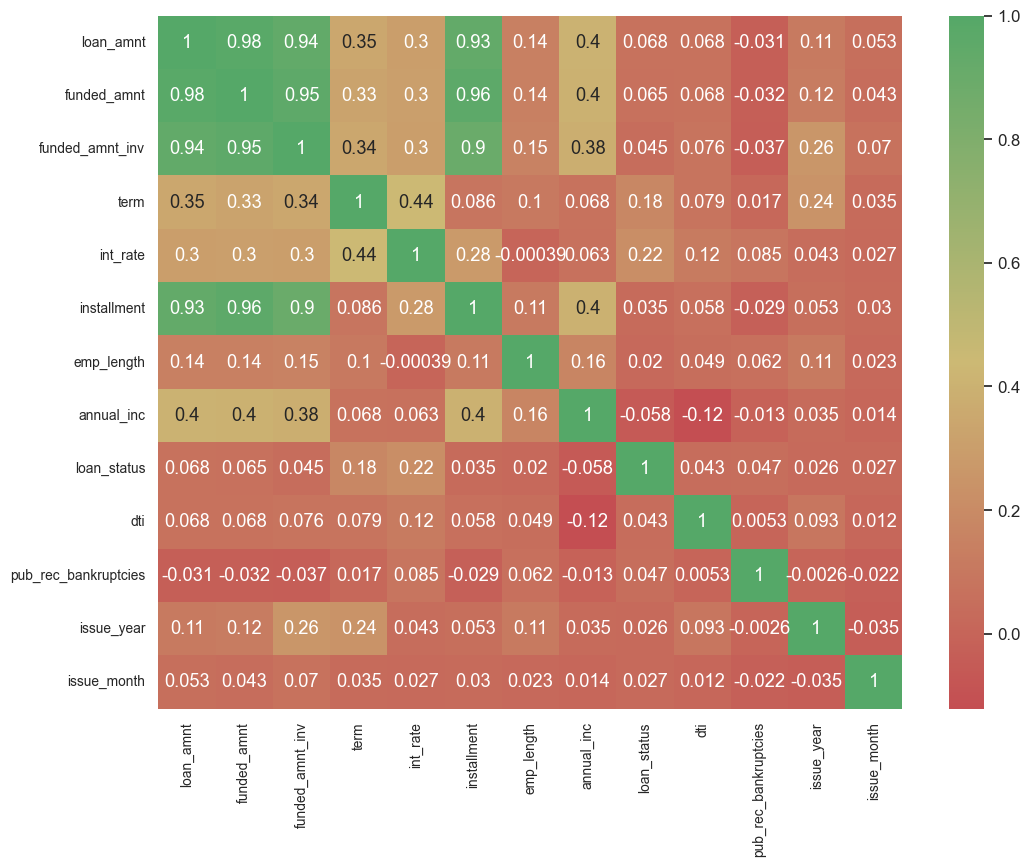

In [424]:
loan_correlation_data = loan.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.1)
color_scheme = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)
sns.heatmap(loan_correlation_data,cmap = color_scheme, ax=ax, annot=True)
plt.show()

#Findings
#1. Term has positive correlation with loan status that implies, chances of default increase with the term.
#2. Interest Rate  has positive correlation with loan status that implies, chances of default increase with the increase in Interest Rate.
#3. Chances of default decreases with increase in annual income as correlation is negative. 
#4. The effect of public record bankruptcies is not much on the loan default.

In [403]:
def countplot(column):
    """
    prints distribution of values in percentages.
    plots a countplot for the provided column
    ** param column: column name
    """
    print(round(100 * loan[column].value_counts()/ loan[column].count(), 2))
    sns.countplot(data=loan, x = column)

loan_status
0    85.62
1    14.38
Name: count, dtype: float64


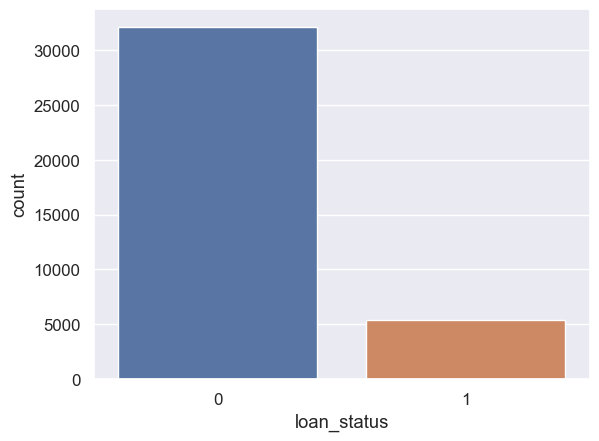

In [404]:
#analysing status of loan as it's one of the most important variables
countplot('loan_status')

#Findings
#---------------------------------------------------
#almost 86 percent people has fully paid their loans
#14 percent has defaulted.
#3 percent are in the process of paying.
#---------------------------------------------------


In [405]:
def remove_outliers(column, min_percentile, max_percentile):
    """
        Removes outliers from a given column
        **param column: column from which outliers should be removed
        **param min_percentile: minimum percentile above which data is consistent
        **param max_percentile: maximum percentile below which data is consistent

        ##Returns the dataframe after removing outliers from it.
    """
    max_percentile_limit = loan[column].quantile(max_percentile)
    min_percentile_limit = loan[column].quantile(min_percentile)
    return loan[((loan[column] > min_percentile_limit) & (loan[column] < max_percentile_limit))]

In [406]:
def describe_and_boxplot(column):
    """
    plots a count plot and prints a description
    
    **param column: column name for count plot
    """
    print(loan[column].describe())

    sns.boxplot(loan[column])
    plt.show()

count    37544.000000
mean     11119.329986
std       7354.098954
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


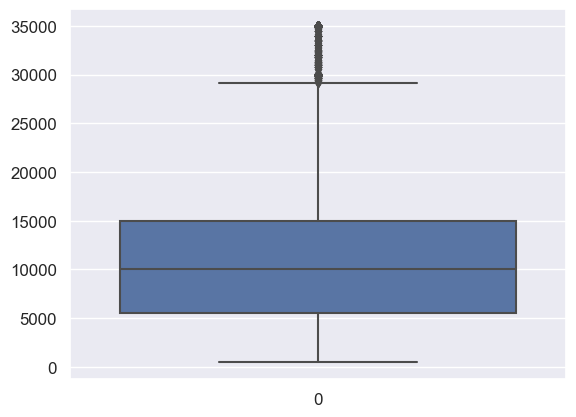

In [407]:
#Loan Amount
describe_and_boxplot('loan_amnt')

#seems like Loan amount is already consistent and doesn't have any outliers

#findings
#1. Average Loan amount is 11119
#2. Most of the loan taken are in the range 5500 - 15000
#3. Maximum loan taken is 35000 and minimum is 500

count    3.754400e+04
mean     6.940708e+04
std      6.467698e+04
min      4.000000e+03
25%      4.100000e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


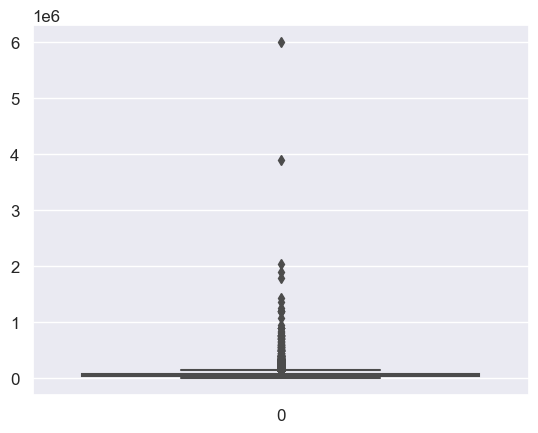

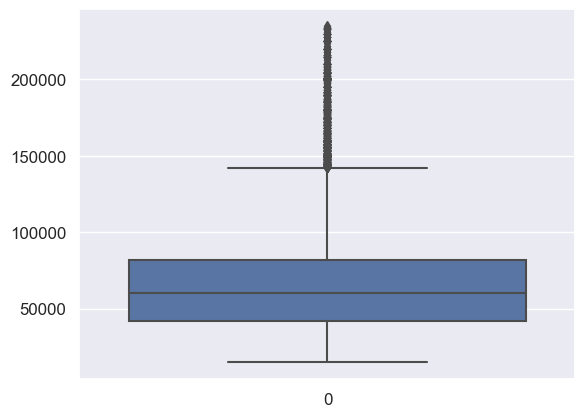

In [408]:
#Annual Income
describe_and_boxplot('annual_inc')


#Seems like data has outliers and we have to remove those outliers
loan = remove_outliers('annual_inc', 0.01, 0.99)
#After removing outliers
sns.boxplot(loan['annual_inc'])
plt.show()

#findings
#1. Average salary is 69407
#2. Maximum salary is 6000000 and minimum is 4000
#3. Most applicants have salary range between 41000 and 83000


count    36762.000000
mean        11.950368
std          3.680300
min          5.420000
25%          8.940000
50%         11.830000
75%         14.410000
max         24.400000
Name: int_rate, dtype: float64


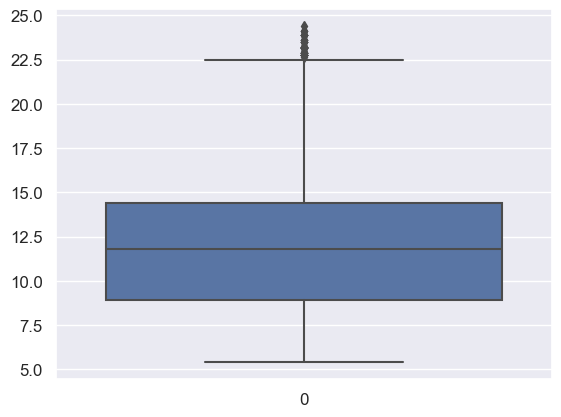

In [409]:
#Interest Rate
describe_and_boxplot('int_rate')
#Seems like interest rate doesn't have any outliers

#findings
#1. Average interest rate is 12%(approximately)
#2. Maximum interest rate is 24.4% and minimum is 5.42%
#3. Most loans have interest rate between 8.94% and 14.41%

count    36762.000000
mean        13.375227
std          6.638618
min          0.000000
25%          8.290000
50%         13.480000
75%         18.620000
max         29.990000
Name: dti, dtype: float64


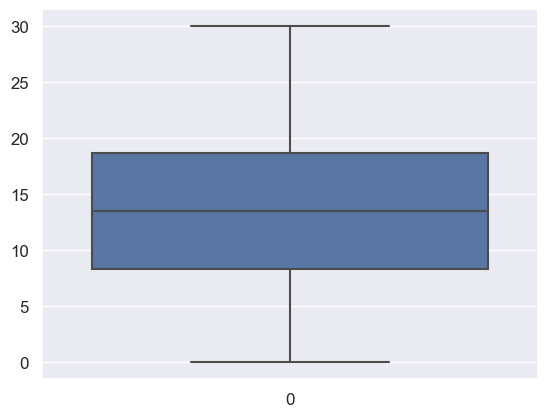

In [410]:
#Debt to income ratio(DTI)
describe_and_boxplot('dti')

#findings
#1. Average DTI is 13(approximately)
#2. Maximum DTI is 30(approximately) and minimum is 0
#3. Most applicants have DTI between 8.29 and 18.62

home_ownership
RENT        48.12
MORTGAGE    44.36
OWN          7.26
OTHER        0.26
NONE         0.01
Name: count, dtype: float64


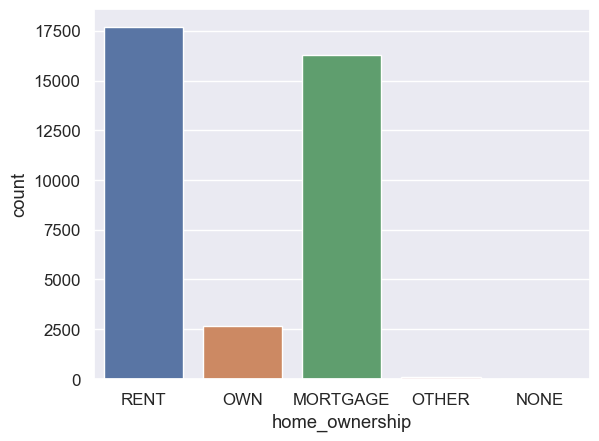

In [411]:
countplot('home_ownership')

#Findings
#1. Most people who take loans are staying at rented houses(48%) or have mortgaged their houses(44%).
#2. People with no houses generally doesn't take any loans(0.01%).

verification_status
Not Verified       43.46
Verified           31.37
Source Verified    25.17
Name: count, dtype: float64


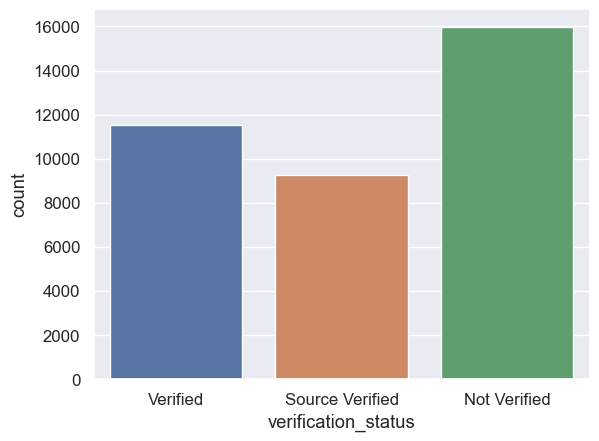

In [412]:
countplot('verification_status')
#Findings
#1. Most of the loans taken are by verified people(25% + 31%)
#2. Non verified people loans are around 43.5%

issue_year
2011    52.91
2010    29.80
2009    12.47
2008     4.17
2007     0.65
Name: count, dtype: float64


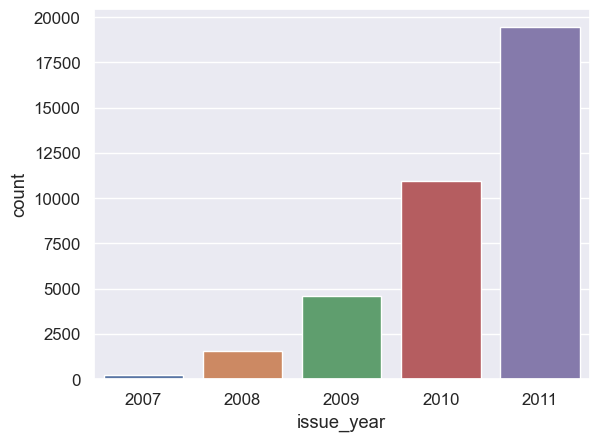

In [413]:
countplot('issue_year')

#Findings
#1. Most loans were taken in the year 2011
#2. In 2007 people took least loans(Loan interest rate might be the reason for this. Maybe in 2007-2008 loan interest rates were high)

issue_month
12    11.02
11    10.33
10     9.66
9      9.06
8      8.88
7      8.66
6      8.24
5      7.56
4      7.36
3      6.98
1      6.18
2      6.08
Name: count, dtype: float64


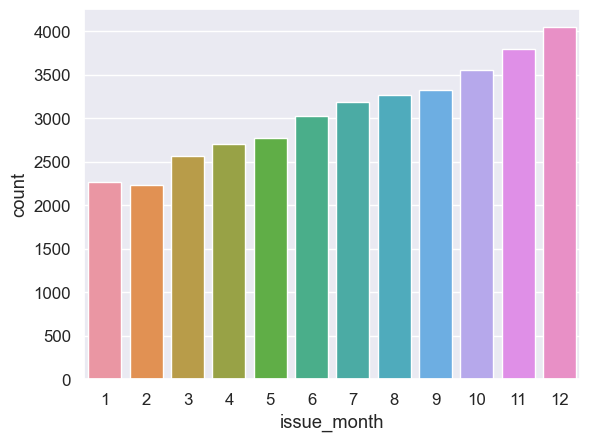

In [414]:
countplot('issue_month')
#Findings
#1. At the start of the year people generally take lesser loans
#2. At the end of the year people generally seems to take more loans.

grade
B    30.31
A    25.83
C    20.40
D    13.20
E     6.93
F     2.54
G     0.78
Name: count, dtype: float64


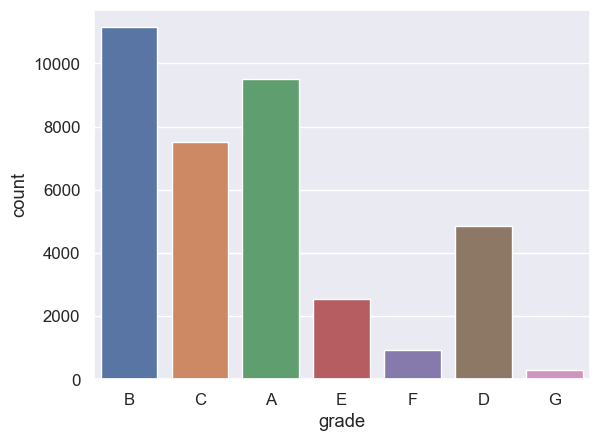

In [415]:
countplot('grade')
#Findings
#1. Grade B generally take more loans than any other grade followed by Grade A and Grade C respectively
#2. Grade F and Grade G applicants take comparatively much lesser loans.

sub_grade
A4    7.48
B3    7.31
A5    7.02
B5    6.85
B4    6.39
C1    5.36
B2    5.17
C2    5.05
A3    4.65
B1    4.59
A2    3.86
C3    3.86
D2    3.33
C4    3.15
C5    2.98
D3    2.90
A1    2.82
D1    2.42
D4    2.39
D5    2.16
E1    1.89
E2    1.60
E3    1.33
E4    1.12
E5    0.98
F1    0.80
F2    0.61
F3    0.45
F4    0.39
F5    0.29
G1    0.25
G2    0.20
G4    0.14
G3    0.12
G5    0.08
Name: count, dtype: float64


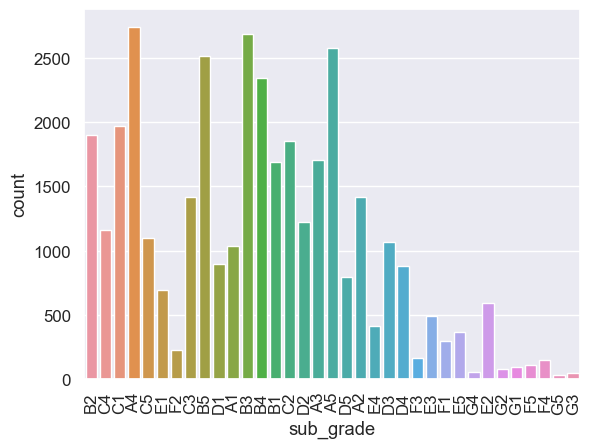

In [416]:
plt.xticks(rotation = 90)
sns.set(font_scale=0.9)
countplot('sub_grade')
#Findings
#1. Grade A4, B3, A5 take almost equal amount of loans and maximum number of loans.
#2. Grade G5 applicants take least amount of loans.

purpose
debt_consolidation    47.33
credit_card           13.14
other                  9.81
home_improvement       7.33
major_purchase         5.52
small_business         4.52
car                    3.83
wedding                2.45
medical                1.74
moving                 1.44
house                  0.93
vacation               0.93
educational            0.77
renewable_energy       0.25
Name: count, dtype: float64


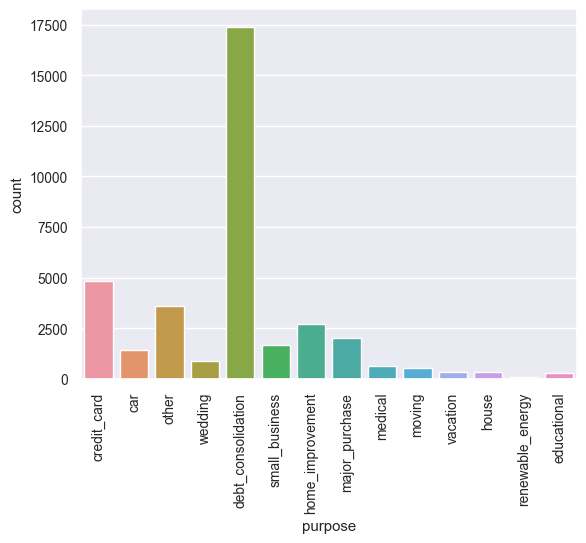

In [417]:
plt.xticks(rotation = 90)
countplot('purpose')

#Findings
#1. almost 50% loans are taken to pay out existing loans.
#2. 13% loans are taken to pay credit card balances.

emp_length
10    22.69
1     20.22
2     11.34
3     10.70
4      8.92
5      8.57
6      5.82
7      4.59
8      3.85
9      3.30
Name: count, dtype: float64


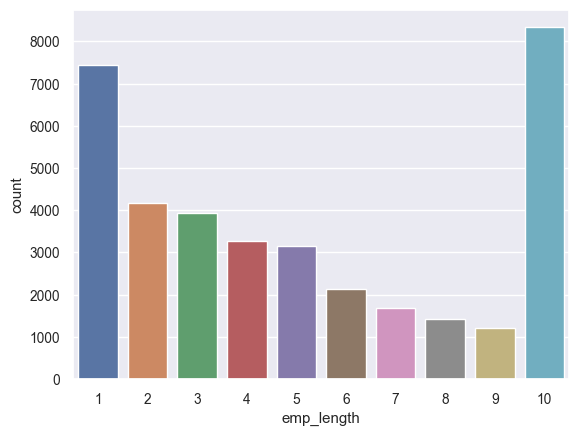

In [418]:
countplot('emp_length')
#Findings
#1. People tend to take loans at the start i.e. 0-1 years of experience or after 10+ years of experience.
#2. for 5-9 years experienced the loans taken are least. 

term
36    75.22
60    24.78
Name: count, dtype: float64


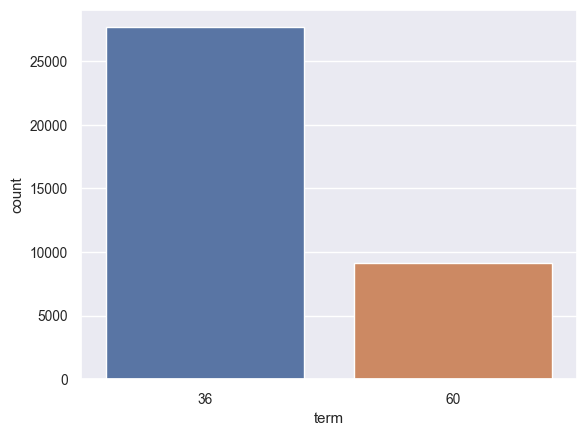

In [419]:
countplot('term')
#Findings
#1. almost 75% loans are of lesser duration i.e. 36 months.
#2. long duration loans(60 months) are around 25%

In [422]:
#Bivariate Analysis

pub_rec_bankruptcies
0    34564
1     1519
2        5
Name: count, dtype: int64